In [8]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np

import plotly.express as px

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import glob as glob
import gzip
import shutil
import xarray as xr


In [130]:
def convert_months_to_date(data_array, start_date): 
    '''
    This function converts the months since a start date to a date. For format dat_array as ds.time, start_date should 'YYYY-MM-DD'
    '''
    array_dates = np.empty(len(data_array)).astype('datetime64[ns]')
    for i in range(len(data_array)):
        array_dates[i] = pd.to_datetime(start_date) + pd.DateOffset(months=np.floor(data_array[i]), days=((data_array[i]%1)*30))
    return array_dates


def convert_years_to_date(data_array, start_date): 
    '''
    This function converts the years since a start date to a date. For format dat_array as ds.time, start_date should 'YYYY-MM-DD'
    '''
    array_dates = np.empty(len(data_array)).astype('datetime64[ns]')
    for i in range(len(data_array)):
        array_dates[i] = pd.to_datetime(start_date) + pd.DateOffset(years=np.floor(data_array[i]), days=((data_array[i]%1)*365))
    return array_dates

In [3]:
folder = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/liquid/"
file = "precip.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz"

In [37]:
files = np.sort(glob.glob(folder + "*.gz"))
for file in files:
    print(file.split("/")[-1])

precip.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz
precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz
runoff.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz
runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz


In [18]:
def open_compressed_xarray(file_path):
    # Path to the compressed file
    compressed_file = file_path

    # Path to the decompressed file
    decompressed_file = compressed_file.replace('.gz', '')

    # Decompress the file
    with gzip.open(compressed_file, 'rb') as f_in:
        with open(decompressed_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Open the decompressed file with xarray
    ds = xr.open_dataset(decompressed_file, engine='netcdf4', decode_times=False)
    return ds
ds = open_compressed_xarray(files[0])

In [32]:
months_since_19400115 = ds.time 
time_line = pd.date_range(start='1940-01-15', periods=len(months_since_19400115), freq='ME')

# ensure that "1940-01-15" is in time.units

assert "1940-01-15" in ds.time.units, "The start date '1940-01-15' is not in the time units."


# Runoff

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_85800/1379803377.py:5: RuntimeWarning: invalid value encountered in cast
  array_dates = np.empty(len(data_array)).astype('datetime64[ns]')


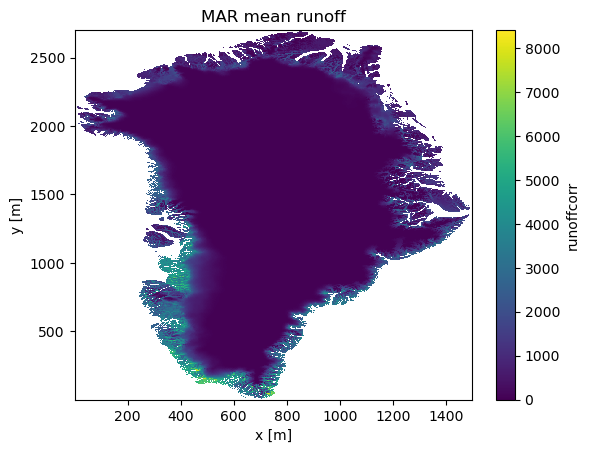

Text(0.5, 1.0, 'MAR mean runoff')

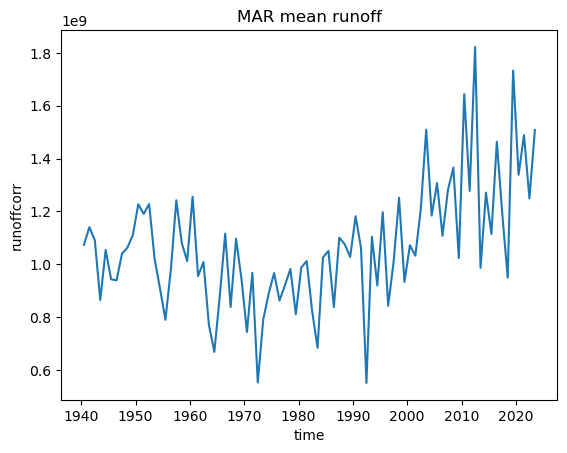

In [137]:

ds_run_MAR = open_compressed_xarray(folder + "runoff.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz")
ds_run_MAR['years_since_19400115'] = ds_run_MAR.time
ds_run_MAR['time'] = convert_months_to_date(ds_run_MAR['years_since_19400115'], '1940-01-15')

ds_run_MAR['runoffcorr'].mean(dim=['time']).plot()
plt.title("MAR mean runoff")
plt.show()
ds_run_MAR['runoffcorr'].sum(dim=['x', 'y']).plot()
plt.title("MAR mean runoff")

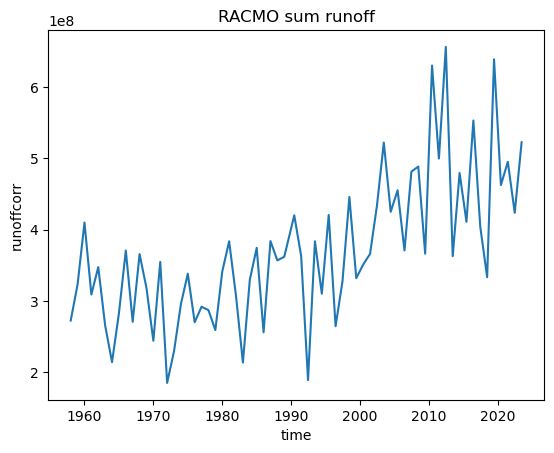

Text(0.5, 1.0, 'RACMO mean runoff')

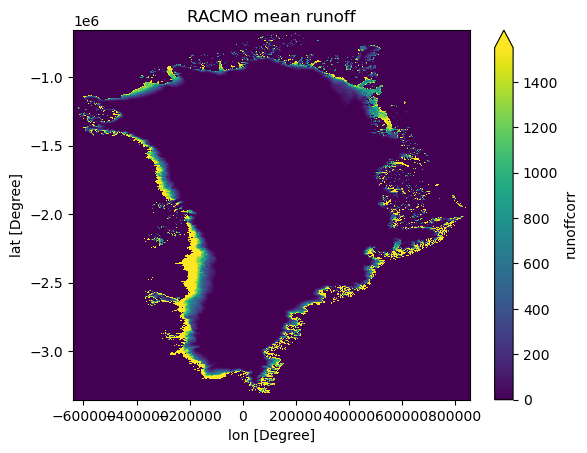

In [138]:
ds_run_RACMO = open_compressed_xarray(folder+ "runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz")
ds_run_RACMO['years_since_19580115'] = ds_run_RACMO.time
ds_run_RACMO['time'] = convert_years_to_date(ds_run_RACMO['years_since_19580115'], '1958-01-15')
ds_run_RACMO['runoffcorr'].sum(dim=['x', 'y']).plot()

plt.title("RACMO sum runoff")
plt.show()
ds_run_RACMO['runoffcorr'].mean(dim=['time']).plot(robust=True)
plt.title("RACMO mean runoff")


## Comparison Runoff

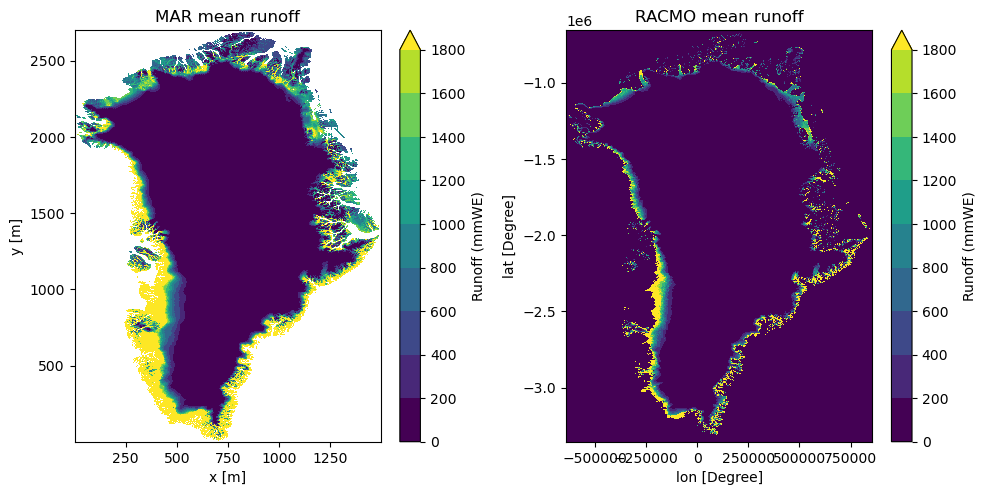

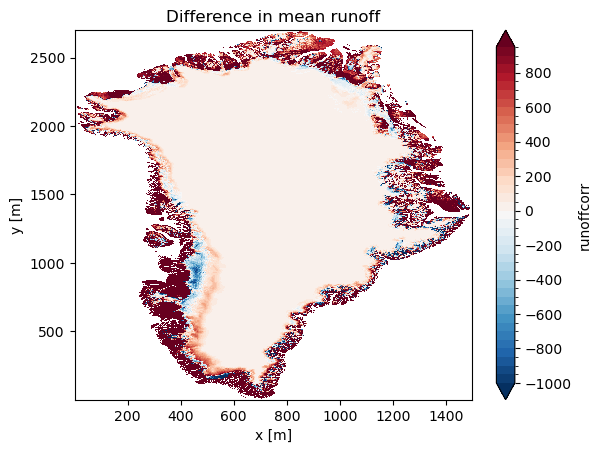

Text(0.5, 1.0, 'Runoff sum')

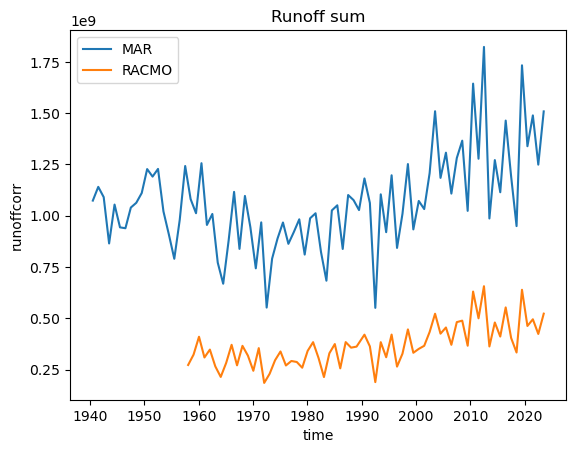

In [157]:
# compare the mean runoff of the two models

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ds_run_MAR['runoffcorr'].sel(time=slice('1958-01-01', '2024-01-01')).mean(dim=['time']).plot(ax=axs[0], label='MAR mean runoff since 1958', levels = np.arange(0,2000, 200), cbar_kwargs={'label': 'Runoff (mmWE)'})
ds_run_RACMO['runoffcorr'].sel(time=slice('1958-01-01', '2024-01-01')).mean(dim=['time']).plot(ax=axs[1], label='RACMO mean runoff since 1958', levels = np.arange(0,2000, 200), cbar_kwargs={'label': 'Runoff (mmWE)'})
plt.tight_layout()
axs[0].set_title("MAR mean runoff")
axs[1].set_title("RACMO mean runoff")

plt.show()

# difference
mean_runoff_MAR = ds_run_MAR['runoffcorr'].sel(time=slice('1998-01-01', '2004-01-01')).mean(dim=['time'])
mean_runoff_RACMO = ds_run_RACMO['runoffcorr'].sel(time=slice('1998-01-01', '2004-01-01')).mean(dim=['time'])
(mean_runoff_MAR - mean_runoff_RACMO.values).plot(levels = np.arange(-1000,1000, 50))
plt.title("Difference in mean runoff")
plt.show()

fig,ax = plt.subplots()
ds_run_MAR['runoffcorr'].sum(dim=['x', 'y']).plot(ax=ax, label='MAR')
ds_run_RACMO['runoffcorr'].sum(dim=['x', 'y']).plot(ax=ax, label='RACMO')
plt.legend()
plt.title("Runoff sum")



# Precipitation

In [106]:
ds_precip_RACMO = open_compressed_xarray(folder + "precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz")
ds_precip_RACMO["year_since_19580115"] = ds_precip_RACMO.time
assert "1958-01-15" in ds_precip_RACMO.time.units, "The start date '1958-01-15' is not in the time units."

ds_precip_MAR = open_compressed_xarray(folder + "precip.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz")
ds_precip_MAR["months_since_19400115"] = ds_precip_MAR.time 
assert "1940-01-15" in ds_precip_MAR.time.units, "The start date '1940-01-15' is not in the time units."

time_line_MAR = convert_months_to_date(ds_precip_MAR["months_since_19400115"], "1940-01-15")
ds_precip_MAR['time'] = time_line_MAR

time_line_RACMO = convert_years_to_date(ds_precip_RACMO["year_since_19580115"], "1958-01-15")
ds_precip_RACMO['time'] = time_line_RACMO



## Comparison Precipitation

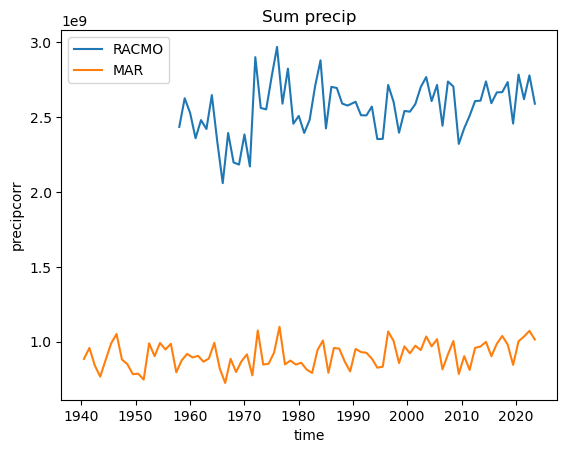

In [148]:
fig, ax = plt.subplots()
ds_precip_RACMO['precipcorr'].sum(dim=['x', 'y']).plot( label = "RACMO", ax=ax)
ds_precip_MAR['precipcorr'].sum(dim=['x', 'y']).plot( label = "MAR", ax=ax)
plt.legend()
plt.title("Sum precip")
plt.show()


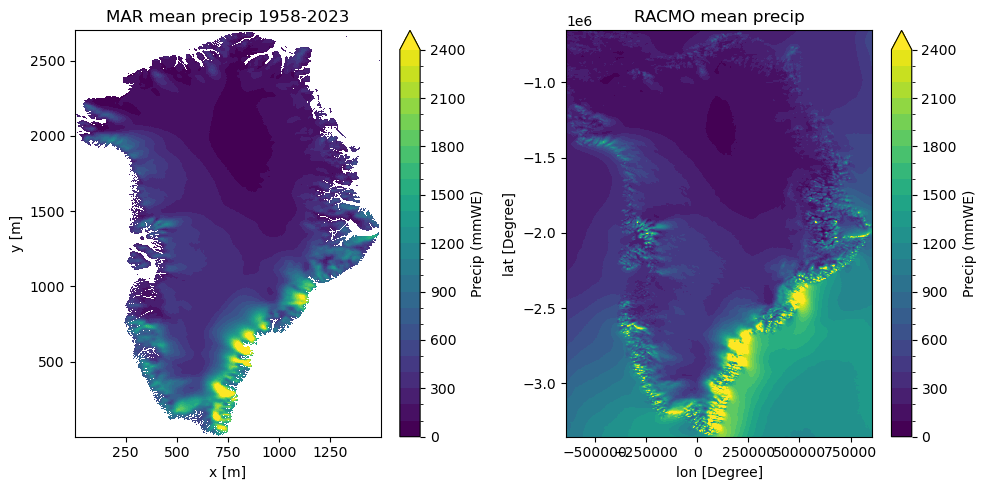

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ds_precip_MAR['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time']).plot( ax=axs[0], levels = np.arange(0,2500,100), cbar_kwargs={'label': 'Precip (mmWE)'})
axs[0].set_title("MAR mean precip 1958-2023")

ds_precip_RACMO['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time']).plot( ax=axs[1], levels = np.arange(0,2500,100), cbar_kwargs={'label': 'Precip (mmWE)'})
axs[1].set_title("RACMO mean precip")
plt.tight_layout()
plt.show()
# difference plot




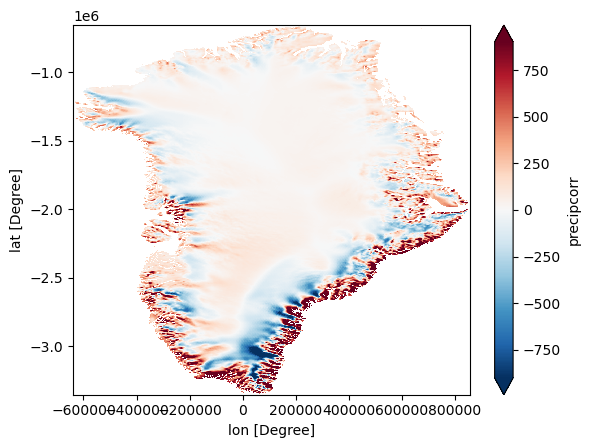

In [129]:
mean_precip_RACMO = (ds_precip_RACMO['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time']))
mean_precip_MAR=  ds_precip_MAR['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time'])
(mean_precip_RACMO - mean_precip_MAR.values).plot(robust=True)

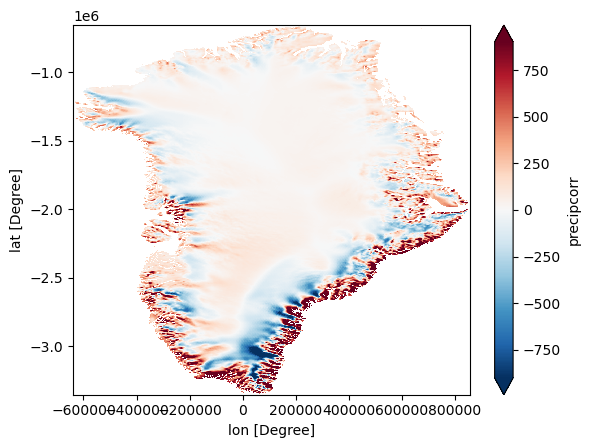

In [123]:
mean_precip_MAR

<xarray.DataArray 'precipcorr' (y: 2700, x: 1496)> Size: 16MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 6kB 1.0 2.0 3.0 4.0 ... 1.494e+03 1.495e+03 1.496e+03
  * y        (y) float32 11kB 1.0 2.0 3.0 4.0 ... 2.698e+03 2.699e+03 2.7e+03